##### Ici on importe notre base de données ( si ca ne marche pas, vous pouvez directement la télécharger depuis le lien ) :

In [67]:
!git clone https://github.com/Ysold/brain-tumor

fatal: destination path 'brain-tumor' already exists and is not an empty directory.


##### Dans ce module on compte le nombre de fichier dans chaque sous fichier, chaque sous fichier correspond au resultat final ( oui ou non)

In [68]:
import os

directory = "brain-tumor/brain_tumor_dataset"
for folder in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, folder)):
        file_count = len(os.listdir(os.path.join(directory, folder)))
        print(f"Le dossier {folder} contient {file_count} fichiers.")

Le dossier no contient 1598 fichiers.
Le dossier yes contient 1655 fichiers.


#### on importe tout les modules nécéssaires pour la création du model :

In [69]:
import cv2
import os
import numpy as np
%pip install tqdm
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf

%pip install plotly
import plotly.graph_objs as go
from plotly.offline import iplot


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D
from tensorflow.keras import Sequential

from keras.models import Sequential

import warnings

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: plotly in c:\users\tristan nio.xps-cbx-tristan\appdata\local\programs\python\python312\lib\site-packages (5.20.0)




[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Étapes de prétraitement pour la détection des tumeurs cérébrales

Après le chargement des fichiers, les premières étapes de prétraitement impliquent :

1. **Redimensionnement des images :**
 Toutes les images sont redimensionnées à une taille prédéfinie pour garantir l'uniformité et la cohérence des dimensions.

2. **Organisation des données :**
 Les images redimensionnées sont ajoutées aux listes avec leurs étiquettes correspondantes, facilitant ainsi l'accès et la gestion lors d'une analyse ultérieure.

In [70]:
mkdir train test val train\yes train\no test\yes test\no val\yes val\no


Un sous-r�pertoire ou un fichier train existe d�j�.
Une erreur s'est produite lors du traitement de�: train.
Un sous-r�pertoire ou un fichier test existe d�j�.
Une erreur s'est produite lors du traitement de�: test.
Un sous-r�pertoire ou un fichier val existe d�j�.
Une erreur s'est produite lors du traitement de�: val.
Un sous-r�pertoire ou un fichier train\yes existe d�j�.
Une erreur s'est produite lors du traitement de�: train\yes.
Un sous-r�pertoire ou un fichier train\no existe d�j�.
Une erreur s'est produite lors du traitement de�: train\no.
Un sous-r�pertoire ou un fichier test\yes existe d�j�.
Une erreur s'est produite lors du traitement de�: test\yes.
Un sous-r�pertoire ou un fichier test\no existe d�j�.
Une erreur s'est produite lors du traitement de�: test\no.
Un sous-r�pertoire ou un fichier val\yes existe d�j�.
Une erreur s'est produite lors du traitement de�: val\yes.
Un sous-r�pertoire ou un fichier val\no existe d�j�.
Une erreur s'est produite lors du traitement de�: val

In [71]:
# COMMANDE POUR GOOGLE COLLAB

# !apt-get install tree
# #clear_output()
# # create new folders
# !mkdir train test val train/yes train/no test/yes test/no val/yes val/no
# !tree -d

In [72]:
IMG_PATH = 'brain-tumor/brain_tumor_dataset/'
# on sépare les données en train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'test/' + CLASS + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'train/'+ CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'val/'+ CLASS + '/' + FILE_NAME)

In [73]:
def load_data(dir_path, img_size=(100,100)):
    """
    Charge les images redimensionnées en tant que np.arrays dans l'espace de travail
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images chargées depuis le répertoire {dir_path}.')
    return X, y, labels

In [74]:
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
VAL_DIR = 'val/'
IMG_SIZE = (224,224)

# utiliser une fonction prédéfinie pour charger les données d'image dans l'espace de travail
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


2593 images chargées depuis le répertoire train/.


100%|██████████| 2/2 [00:00<00:00, 158.35it/s]


10 images chargées depuis le répertoire test/.


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

650 images chargées depuis le répertoire val/.


In [75]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [76]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Crée un grille pour le nombre souhaité d'images (n) à partir de l'ensemble spécifié
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

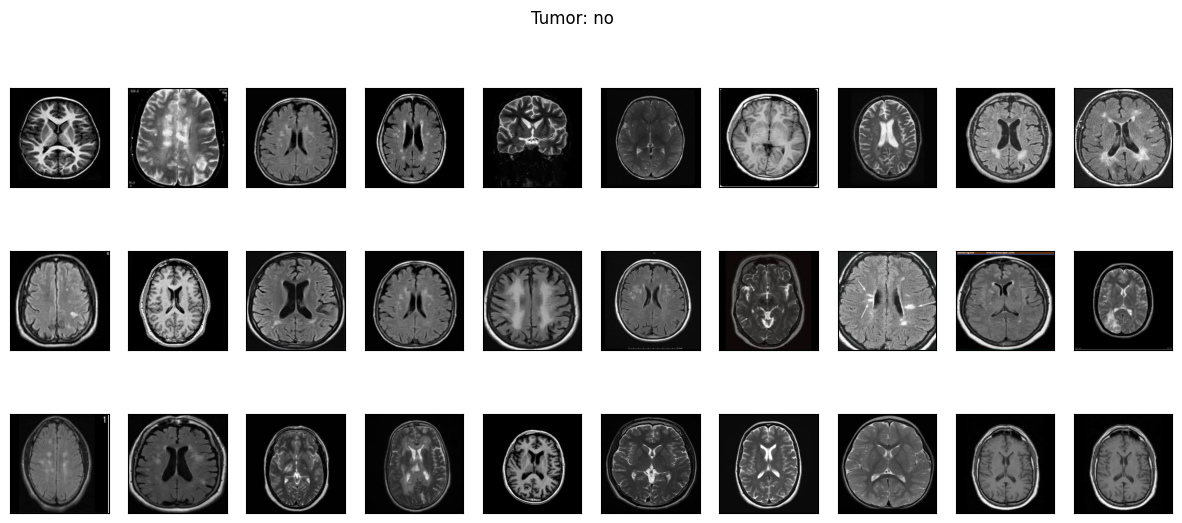

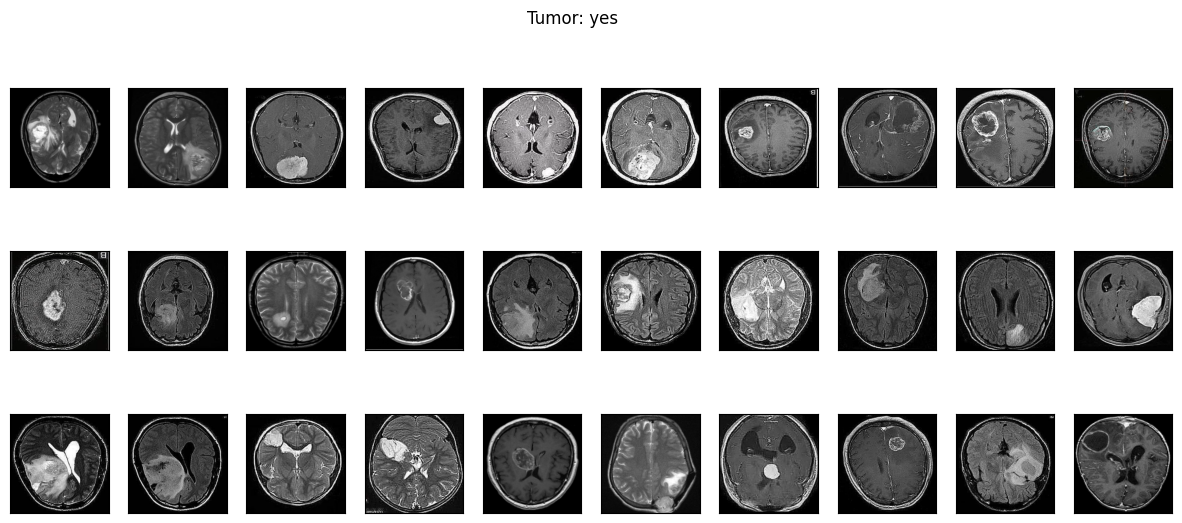

In [77]:
plot_samples(X_train, y_train, labels, 30)

In [78]:
x_train= X_train /255.0
x_test = X_test / 255.0


In [79]:
print("Minimum value of the scaled data:", x_train.min())
print("Maximum value of the scaled data:",  x_train.max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


#### Initialisation du modèle séquentiel

création des couches de convolution ( Conv2D : opération qui applique un filtre sur l'image d'entrée pour extraire des caractéristiques locales ) avec ReLU ( fonction qui remplace toutes les valeurs négatives dans la carte de caractérisques par zéro ) suivie d'un max-pooling ( opération qui réduit la dimensionnalité de chaque carte de caractéristiques )

Aplatissement ( Flatten : transforme les carte 2D en vecteur 1D ) des cartes de caractéristiques et ajout de couches denses avec dropout ( 50% des neurones sont mise à zero )

In [80]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))



In [81]:
# Compilation du modèle avec l'optimiseur Adam, la fonction de perte binaire cross-entropy et la métrique d'exactitude
model.compile(
    optimizer='Adam',              # Utilisation de l'optimiseur Adam, qui adapte les taux d'apprentissage pour chaque paramètre
    loss='binary_crossentropy',    # Fonction de perte pour la classification binaire
    metrics=['accuracy']           # Suivi de la métrique d'exactitude pendant l'entraînement et l'évaluation
)

In [82]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
# Fonction de "early call" qui va arreter la construction du model quand l'accuracy atteindra 99%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True
            
back = myCallback()     

In [84]:
history = model.fit(x_train, 
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks=[back])

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.6491 - loss: 0.7174 - val_accuracy: 0.9538 - val_loss: 0.2446
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.8550 - loss: 0.3330 - val_accuracy: 0.9576 - val_loss: 0.1660
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.9154 - loss: 0.2117 - val_accuracy: 0.9865 - val_loss: 0.0654
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.9488 - loss: 0.1399 - val_accuracy: 0.9557 - val_loss: 0.1400
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.9716 - loss: 0.0866 - val_accuracy: 0.9538 - val_loss: 0.1559
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.9714 - loss: 0.0758 - val_accuracy: 0.9769 - val_loss: 0.0857
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.9811 - loss: 0.0536 - val_accuracy: 0.9769 - val_loss: 0.0835
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9969 - loss: 0.0268
Rea

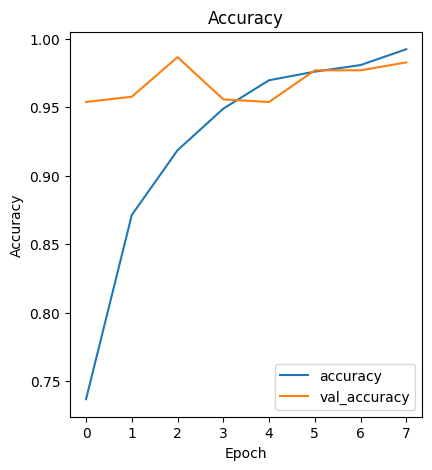

In [85]:
# graphique de la précision et de la perte de donnée
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

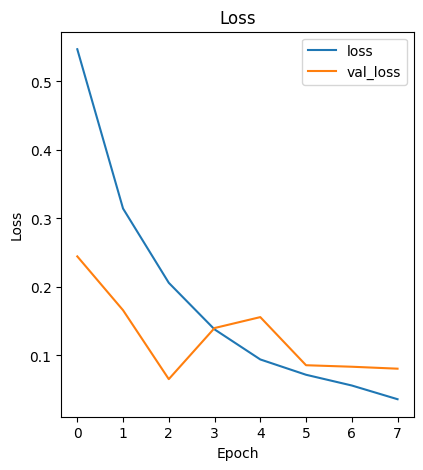

In [86]:
# graphique model loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()


In [87]:

# Evaluation du model
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0175
Test Loss: 0.01747593656182289
Test Accuracy: 1.0


In [88]:
# sauvegarde du model
model.save("model.h5")
